In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: bfloat16
Variable dtype: float32


In [4]:
import tensorflow as tf
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.experimental.net2net import Net2Net
import tensorflow_addons as tfa
from datetime import datetime
from tqdm import tqdm
from pyprojroot.pyprojroot import here

#tf.get_logger().setLevel('WARNING')
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-06-14 05:07:39.036799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operatio

In [6]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/moving_mnist_image_transformer_huggingface.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = cfg["train"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["train"]["n_epochs"]

In [8]:
dataset_length = 10000
num_batch = dataset_length / batch_size

In [9]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

In [10]:
dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = dataset.shuffle(dataset_length, reshuffle_each_iteration=True).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [11]:
train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [12]:
train_ds = dataset.take(train_size)#.batch(global_batch_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.batch(global_batch_size)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.batch(global_batch_size)

In [13]:
train_sample_data = next(train_ds.batch(batch_size).as_numpy_iterator())
validation_sample_data = next(validation_ds.batch(batch_size).as_numpy_iterator())

In [14]:
train_ds = train_ds.batch(global_batch_size, drop_remainder=True)
validation_ds = validation_ds.batch(global_batch_size, drop_remainder=True)
test_ds = test_ds.batch(global_batch_size, drop_remainder=True)

In [15]:
from ganime.utils.callbacks import TensorboardVideo, get_logdir
import os

logdir = get_logdir("../../../logs/ganime/transformers", experiment_name="mnist_video")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_video_callback = TensorboardVideo(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_loss', save_best_only=True, save_weights_only=True)
callbacks = [tensorboard_callback, early_stopping, checkpointing, tensorboard_video_callback]
#callbacks = [tensorboard_callback, tensorboard_video_callback]

In [16]:
images = train_sample_data["y"][:,0,...]

In [17]:
with strategy.scope():
    model = Net2Net(**cfg["model"], trainer_config=cfg["train"])
    #model.build(train_sample_data["y"].shape)#first_stage_model.build(train_sample_data["y"].shape[1:])
    #model.first_stage_model.build(train_sample_data["y"].shape[1:])

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:

In [18]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str("../../../checkpoints/tflite/encoder_quant_f16.tflite"))
#interpreter_fp16.allocate_tensors()

In [21]:
output_shape = interpreter_fp16.get_input_details()[0]['shape']
interpreter_fp16.resize_tensor_input(interpreter_fp16.get_input_details()[0]["index"],[32, output_shape[1], output_shape[2], output_shape[3]])
interpreter_fp16.allocate_tensors()

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index_1 = interpreter_fp16.get_output_details()[0]["index"]
output_index_2 = interpreter_fp16.get_output_details()[1]["index"]
output_index_3 = interpreter_fp16.get_output_details()[2]["index"]

interpreter_fp16.set_tensor(input_index, images)
interpreter_fp16.invoke()
out1 = interpreter_fp16.get_tensor(output_index_1)
out2 = interpreter_fp16.get_tensor(output_index_2)
out3 = interpreter_fp16.get_tensor(output_index_3)

In [19]:
quant_16, indices_16 = model.encode_to_z(images)

InternalError: Graph execution error:

Detected at node 'encoder/conv2d/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 707, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 502, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 491, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 398, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 722, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 389, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_21768/3953791806.py", line 1, in <cell line: 1>
      quant_16, indices_16 = model.encode_to_z(images)
    File "/GANime/ganime/model/vqgan_clean/experimental/net2net.py", line 114, in encode_to_z
      quant_z, indices, quantized_loss = self.first_stage_model.encode(x)
    File "/GANime/ganime/model/vqgan_clean/vqgan.py", line 183, in encode
      h = self.encoder(x)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/GANime/ganime/model/vqgan_clean/diffusion/encoder.py", line 115, in call
      h = self.conv_in(inputs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'encoder/conv2d/Conv2D'
Detected at node 'encoder/conv2d/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 707, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 502, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 491, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 398, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 722, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 389, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_21768/3953791806.py", line 1, in <cell line: 1>
      quant_16, indices_16 = model.encode_to_z(images)
    File "/GANime/ganime/model/vqgan_clean/experimental/net2net.py", line 114, in encode_to_z
      quant_z, indices, quantized_loss = self.first_stage_model.encode(x)
    File "/GANime/ganime/model/vqgan_clean/vqgan.py", line 183, in encode
      h = self.encoder(x)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/GANime/ganime/model/vqgan_clean/diffusion/encoder.py", line 115, in call
      h = self.conv_in(inputs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'encoder/conv2d/Conv2D'
2 root error(s) found.
  (0) INTERNAL:  Missing 0-th output from {{node encoder/conv2d/Conv2D}}
	 [[encoder/resnet_block_3/conv2d_11/BiasAdd/Cast/_161]]
  (1) INTERNAL:  Missing 0-th output from {{node encoder/conv2d/Conv2D}}
0 successful operations.
0 derived errors ignored. [Op:__inference_encode_to_z_3574]

In [32]:
quant_16 = model.first_stage_model.quantize.get_codebook_entry(
    indices,
    shape=quant_16.shape,
)

In [59]:
reconstructed_16 = model.first_stage_model.decode(quant_16)

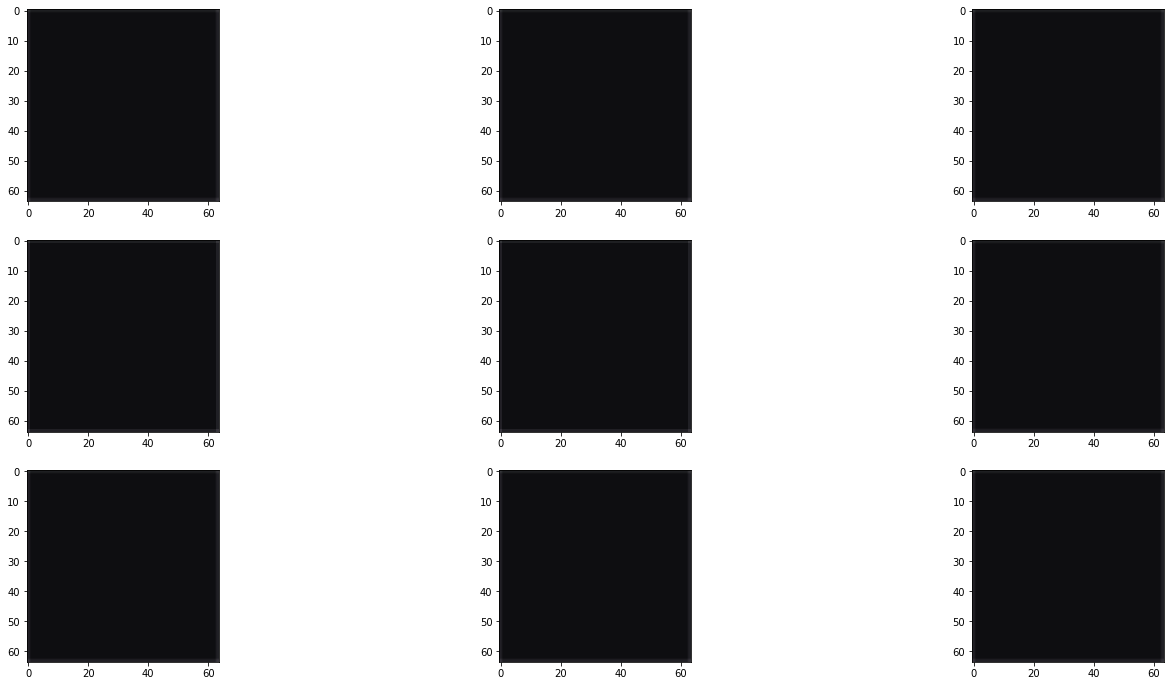

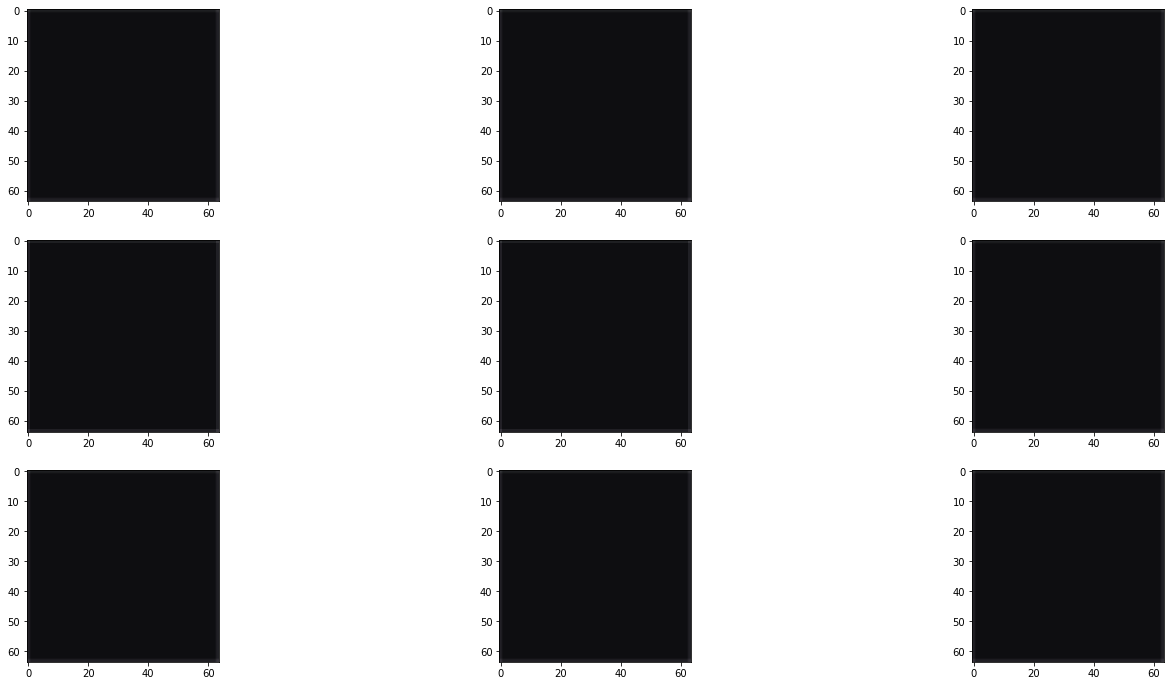

In [37]:
display_images(reconstructed_16)

In [35]:
quant_16

<tf.Tensor: shape=(32, 8, 8, 128), dtype=float32, numpy=
array([[[[-2.02392578e-01,  8.38012695e-02, -2.71972656e-01, ...,
          -2.08862305e-01,  2.79541016e-01,  2.26074219e-01],
         [ 1.66503906e+00,  1.06835938e+00,  3.50097656e-01, ...,
          -2.80273438e-01, -1.59912109e-01, -1.31835938e+00],
         [ 1.41210938e+00, -6.62109375e-01,  1.71972656e+00, ...,
           1.33984375e+00, -1.14160156e+00, -1.45629883e-01],
         ...,
         [-4.74609375e-01, -4.83154297e-01, -6.57348633e-02, ...,
          -1.76269531e-01, -7.86132812e-02,  2.41821289e-01],
         [ 2.70312500e+00,  3.95263672e-01,  1.98535156e+00, ...,
           1.50488281e+00, -1.03027344e+00, -6.87500000e-01],
         [-8.62304688e-01,  8.78906250e-02, -8.31542969e-01, ...,
          -6.14257812e-01,  6.31835938e-01,  5.63964844e-01]],

        [[-1.39257812e+00, -4.34082031e-01, -7.50488281e-01, ...,
          -2.58056641e-01,  6.14257812e-01,  1.20703125e+00],
         [ 1.56445312e+00,  1.4

In [17]:
quant, indices = model.encode_to_z(images)

2022-06-14 04:38:57.324756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-06-14 04:38:58.834948: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [20]:
quant = model.first_stage_model.quantize.get_codebook_entry(
    indices,
    shape=quant.shape,
)

In [21]:
reconstructed = model.first_stage_model.decode(quant)

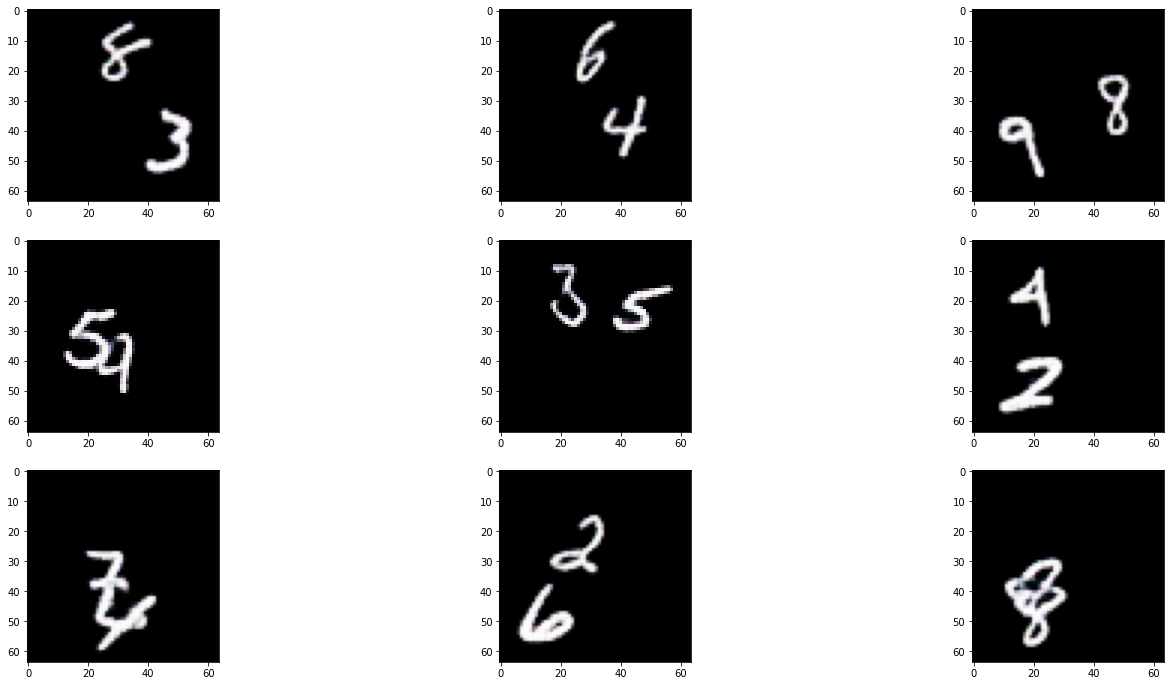

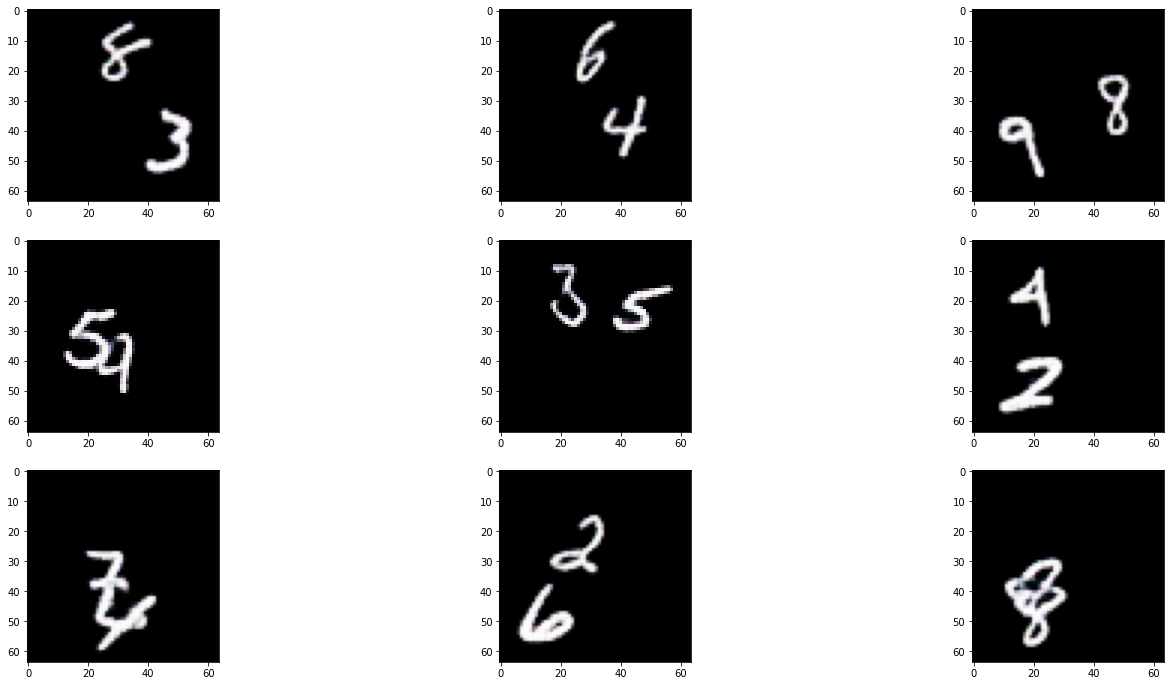

In [22]:
display_images(reconstructed)

In [18]:
display_videos(model(train_sample_data))

2022-06-14 02:30:06.399042: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


InvalidArgumentError: Exception encountered when calling layer "net2_net" (type Net2Net).

cannot compute BatchMatMulV2 as input #1(zero-based) was expected to be a float tensor but is a half tensor [Op:BatchMatMulV2]

Call arguments received:
  • inputs={'first_frame': 'tf.Tensor(shape=(32, 64, 64, 3), dtype=float16)', 'last_frame': 'tf.Tensor(shape=(32, 64, 64, 3), dtype=float16)', 'y': 'tf.Tensor(shape=(32, 20, 64, 64, 3), dtype=float16)', 'n_frames': 'tf.Tensor(shape=(32,), dtype=int32)'}
  • training=None
  • mask=None

In [20]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [21]:
print_gpu_utilization()

GPU memory occupied: 3609 MB.


In [20]:
model.fit(train_ds, validation_data=validation_ds, epochs=cfg["train"]["n_epochs"], callbacks=callbacks)

Epoch 1/50
     31/Unknown - 148s 4s/step - loss: 133.9594

2022-06-13 14:12:56.243204: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_707881"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:366"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. 

Instructions for updating:
use `experimental_local_results` instead.


2022-06-13 14:16:38.839928: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_778077"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:408"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. 

31/31 [==============================] - 747s 24s/step - loss: 133.9594 - val_loss: 130.1730
Epoch 2/50
 6/31 [====>.........................] - ETA: 1:44 - loss: 130.0363

KeyboardInterrupt: 

In [21]:
generated_videos = model.generate_video(train_sample_data["first_frame"], train_sample_data["last_frame"], 20)

In [22]:
display_videos(generated_videos)

In [19]:
quant_z, indices = model.encode_to_z(images)

2022-06-13 07:51:54.442221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


In [20]:
quant = model.first_stage_model.quantize.get_codebook_entry(
    indices, shape=tf.shape(quant_z)
)
decoded = model.first_stage_model.decode(quant)

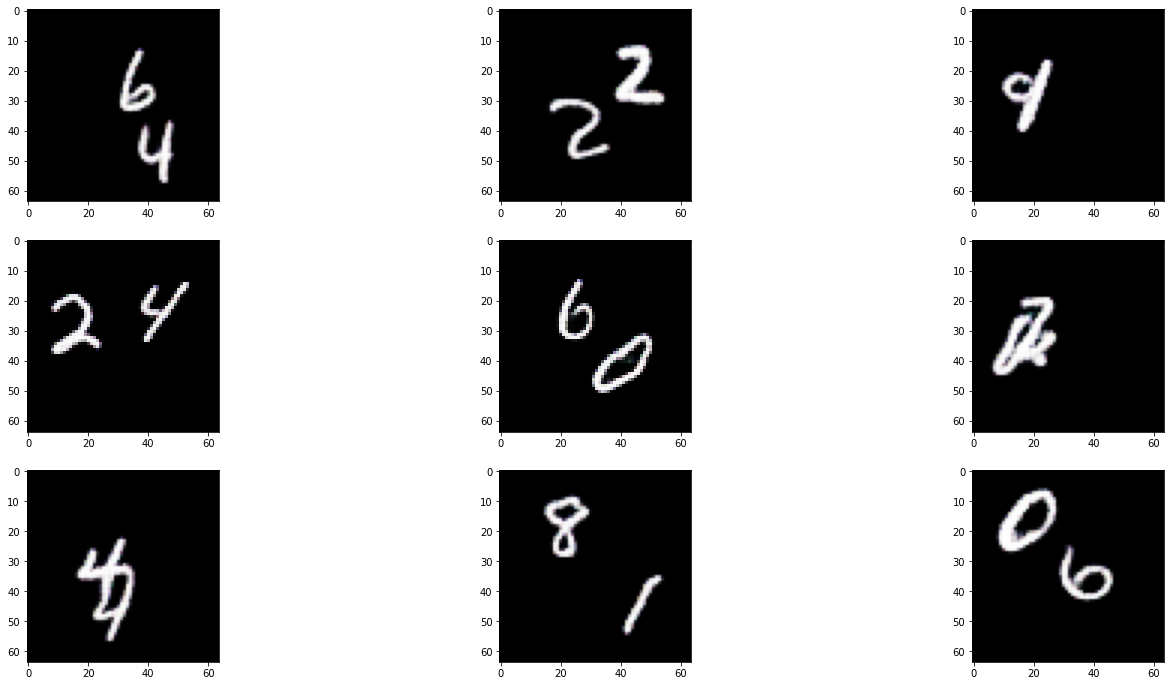

In [21]:
display_images(decoded)
plt.show()